In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay

In [3]:
df = pd.read_csv('./Dataset/ieee-fraud-detection/train_transaction.csv')
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


In [10]:
df.shape

(590540, 394)

In [8]:
df.isnull().sum()

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
                   ...  
V335              508189
V336              508189
V337              508189
V338              508189
V339              508189
Length: 394, dtype: int64

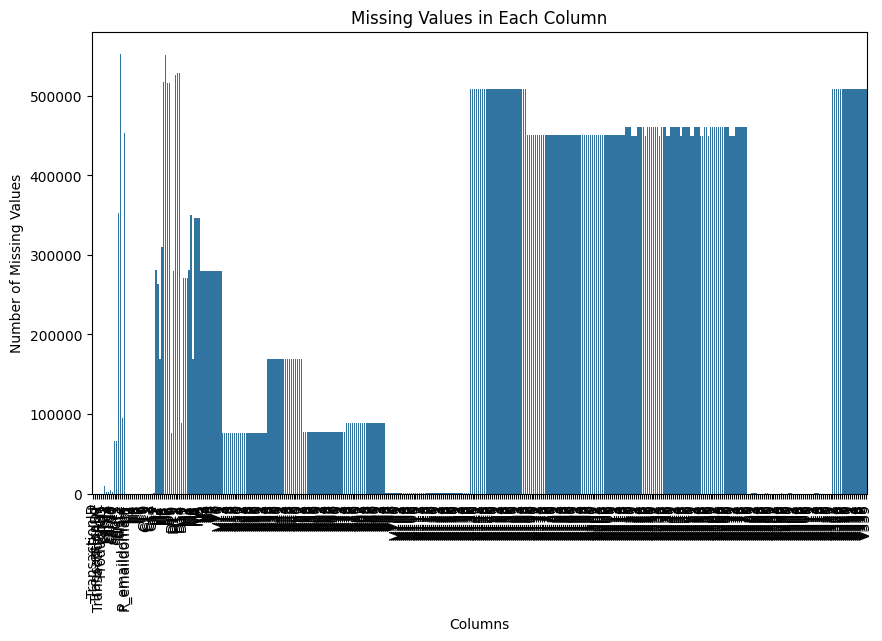

In [7]:
missing_values = df.isnull().sum()

# Create a bar plot to visualize missing values
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.index, y=missing_values.values)

# Rotate the x labels for better readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values in Each Column')

# Show the plot
plt.show()

In [5]:
df['isFraud'].value_counts()

isFraud
0    569877
1     20663
Name: count, dtype: int64

**Số bản ghi là giao dịch giả mạo**
- Không giả mạo: 569877
- Giả mạo: 20663

In [19]:
# Split the data based on isFraud value
fraud_0 = df[df['isFraud'] == 0]
fraud_1 = df[df['isFraud'] == 1]

In [23]:
fraud_0.shape[0]
fraud_1.shape[0]

20663

In [26]:
rate = (fraud_1.shape[0] / fraud_0.shape[0] ) * 100
rate

3.625870143908247

In [27]:
# Take 80% of isFraud = 0 and 20% of isFraud = 1
sample_size = 20000
sample_0 = fraud_0.sample(frac=0.964 * (sample_size / len(df)), random_state=42)
sample_1 = fraud_1.sample(frac=0.036 * (sample_size / len(df)), random_state=42)

In [29]:
# Combine the samples
sample_df = pd.concat([sample_0, sample_1])

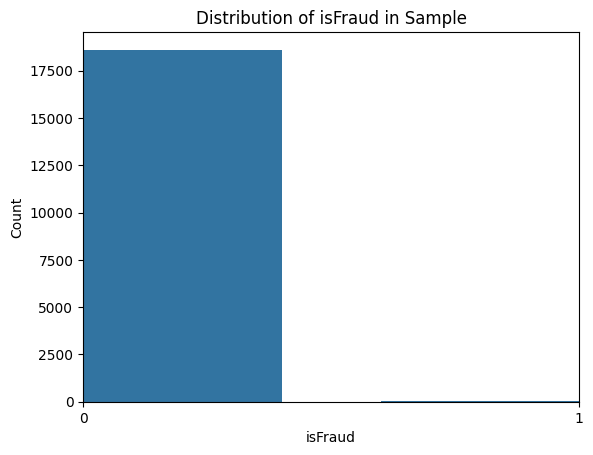

In [30]:
# Visualize the distribution of isFraud in the sample
sns.countplot(x=sample_df['isFraud'])
plt.title('Distribution of isFraud in Sample')
plt.xlabel('isFraud')
plt.ylabel('Count')
plt.xlim([0, 1])

# Show the plot
plt.show()

In [32]:
df = sample_df

In [33]:
df.shape

(18630, 394)

**Tạo một DataFrame từ dữ liệu**

In [46]:
columns_of_interest = ['isFraud','TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'addr1', 'dist1', 'P_emaildomain', 'dist2', 'R_emaildomain', 'C1']
data = pd.DataFrame()
for column in columns_of_interest:
    data[column] = df[column].sample(40, random_state= 1).reset_index(drop= True) ## Lấy nn 40 dòng đầu tiên, state = 1 đảm bảo tính giống nhau trong nhiều lần lấy
    
data.fillna(0, inplace=True)

In [47]:
data.shape

(40, 14)

In [49]:
data

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,addr1,dist1,P_emaildomain,dist2,R_emaildomain,C1
0,0,378.000,W,16658,555.0,150.0,visa,226.0,512.0,11.0,outlook.com,0.0,0,3.0
1,0,117.000,W,17300,555.0,159.0,mastercard,137.0,330.0,9.0,gmail.com,0.0,0,1.0
2,0,57.000,W,10023,111.0,150.0,visa,226.0,325.0,4.0,gmail.com,0.0,0,1.0
3,0,117.000,W,16132,111.0,150.0,visa,226.0,299.0,0.0,aol.com,0.0,0,1.0
4,0,100.000,R,3094,276.0,150.0,visa,226.0,191.0,0.0,anonymous.com,0.0,anonymous.com,1.0
5,0,117.000,W,7861,494.0,150.0,visa,226.0,512.0,8.0,0,0.0,0,4.0
6,0,226.000,W,17746,327.0,150.0,discover,100.0,433.0,5.0,me.com,0.0,0,2.0
7,0,14.204,C,6585,406.0,117.0,mastercard,166.0,0.0,0.0,anonymous.com,228.0,anonymous.com,3.0
8,0,108.510,W,7508,321.0,150.0,visa,226.0,110.0,6.0,gmail.com,0.0,0,1.0
9,0,59.000,W,12695,490.0,150.0,visa,226.0,325.0,63.0,gmail.com,0.0,0,3.0


**Tập dữ liệu cần giảm chiều**

In [50]:
X = data.drop(columns= ['P_emaildomain', 'dist2', 'R_emaildomain', 'C1', 'isFraud'])
X.head(10)

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,addr1,dist1
0,378.000,W,16658,555.0,150.0,visa,226.0,512.0,11.0
1,117.000,W,17300,555.0,159.0,mastercard,137.0,330.0,9.0
2,57.000,W,10023,111.0,150.0,visa,226.0,325.0,4.0
3,117.000,W,16132,111.0,150.0,visa,226.0,299.0,0.0
4,100.000,R,3094,276.0,150.0,visa,226.0,191.0,0.0
5,117.000,W,7861,494.0,150.0,visa,226.0,512.0,8.0
6,226.000,W,17746,327.0,150.0,discover,100.0,433.0,5.0
7,14.204,C,6585,406.0,117.0,mastercard,166.0,0.0,0.0
8,108.510,W,7508,321.0,150.0,visa,226.0,110.0,6.0
9,59.000,W,12695,490.0,150.0,visa,226.0,325.0,63.0


**Sử dụng One-Hot Encoding cho các thuộc tính phân loại như ProductCD và card4**

In [53]:
X['ProductCD'].unique()

array(['W', 'R', 'C', 'H', 'S'], dtype=object)

In [51]:
dummies_ProductCD = pd.get_dummies(X['ProductCD'], prefix='ProductCD', drop_first=True)

In [52]:
dummies_ProductCD = dummies_ProductCD.astype(int)
dummies_ProductCD

,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,1,0,0
5,0,0,0,1
6,0,0,0,1
7,0,0,0,0
8,0,0,0,1
9,0,0,0,1


In [62]:
X['card4'].unique()

array(['visa', 'mastercard', 'discover'], dtype=object)

In [58]:
dummies_card4 = pd.get_dummies(X['card4'], prefix='card4', drop_first=True)

In [63]:
dummies_card4 = dummies_card4.astype(int)
print(dummies_card4)

    card4_mastercard  card4_visa
0                  0           1
1                  1           0
2                  0           1
3                  0           1
4                  0           1
5                  0           1
6                  0           0
7                  1           0
8                  0           1
9                  0           1
10                 1           0
11                 0           1
12                 0           1
13                 0           1
14                 0           1
15                 0           1
16                 1           0
17                 1           0
18                 0           1
19                 1           0
20                 0           1
21                 1           0
22                 0           1
23                 0           1
24                 0           1
25                 0           1
26                 0           1
27                 1           0
28                 1           0
29        

In [64]:
drop_view = X.drop(columns= ['ProductCD', 'card4'], axis=1)
drop_view.head(10)

,TransactionAmt,card1,card2,card3,card5,addr1,dist1
0,378.000,16658,555.0,150.0,226.0,512.0,11.0
1,117.000,17300,555.0,159.0,137.0,330.0,9.0
2,57.000,10023,111.0,150.0,226.0,325.0,4.0
3,117.000,16132,111.0,150.0,226.0,299.0,0.0
4,100.000,3094,276.0,150.0,226.0,191.0,0.0
5,117.000,7861,494.0,150.0,226.0,512.0,8.0
6,226.000,17746,327.0,150.0,100.0,433.0,5.0
7,14.204,6585,406.0,117.0,166.0,0.0,0.0
8,108.510,7508,321.0,150.0,226.0,110.0,6.0
9,59.000,12695,490.0,150.0,226.0,325.0,63.0


In [65]:
df_combined = pd.concat([drop_view, dummies_ProductCD, dummies_card4], axis=1)
print(df_combined)

    TransactionAmt  card1  card2  card3  card5  addr1  dist1  ProductCD_H  \
0          378.000  16658  555.0  150.0  226.0  512.0   11.0            0   
1          117.000  17300  555.0  159.0  137.0  330.0    9.0            0   
2           57.000  10023  111.0  150.0  226.0  325.0    4.0            0   
3          117.000  16132  111.0  150.0  226.0  299.0    0.0            0   
4          100.000   3094  276.0  150.0  226.0  191.0    0.0            0   
5          117.000   7861  494.0  150.0  226.0  512.0    8.0            0   
6          226.000  17746  327.0  150.0  100.0  433.0    5.0            0   
7           14.204   6585  406.0  117.0  166.0    0.0    0.0            0   
8          108.510   7508  321.0  150.0  226.0  110.0    6.0            0   
9           59.000  12695  490.0  150.0  226.0  325.0   63.0            0   
10         335.000   7919  194.0  150.0  202.0  512.0    0.0            0   
11         226.000  14065  298.0  150.0  195.0  272.0   15.0            0   

In [66]:
df_combined.head(10)

,TransactionAmt,card1,card2,card3,card5,addr1,dist1,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_mastercard,card4_visa
0,378.000,16658,555.0,150.0,226.0,512.0,11.0,0,0,0,1,0,1
1,117.000,17300,555.0,159.0,137.0,330.0,9.0,0,0,0,1,1,0
2,57.000,10023,111.0,150.0,226.0,325.0,4.0,0,0,0,1,0,1
3,117.000,16132,111.0,150.0,226.0,299.0,0.0,0,0,0,1,0,1
4,100.000,3094,276.0,150.0,226.0,191.0,0.0,0,1,0,0,0,1
5,117.000,7861,494.0,150.0,226.0,512.0,8.0,0,0,0,1,0,1
6,226.000,17746,327.0,150.0,100.0,433.0,5.0,0,0,0,1,0,0
7,14.204,6585,406.0,117.0,166.0,0.0,0.0,0,0,0,0,1,0
8,108.510,7508,321.0,150.0,226.0,110.0,6.0,0,0,0,1,0,1
9,59.000,12695,490.0,150.0,226.0,325.0,63.0,0,0,0,1,0,1


**Chuẩn hóa dữ liệu**

**Các giá trị số cần được chuẩn hóa bằng cách trừ đi giá trị trung bình và chia cho độ lệch chuẩn để tất cả các thuộc tính có cùng thang đo**

In [67]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_combined)

In [68]:
print(X_scaled)

[[ 3.30538773e+00  1.38835631e+00  1.56454472e+00 -1.78883001e-01
   7.18612989e-01  1.54110697e+00 -9.64095680e-02 -2.29415734e-01
  -1.60128154e-01 -1.60128154e-01  6.15881762e-01 -6.15881762e-01
   6.54653671e-01]
 [ 2.14790581e-01  1.52038535e+00  1.56454472e+00  4.22966348e-01
  -1.73182977e+00  3.76074910e-01 -1.55738533e-01 -2.29415734e-01
  -1.60128154e-01 -1.60128154e-01  6.15881762e-01  1.62368828e+00
  -1.52752523e+00]
 [-4.95691523e-01  2.38505732e-02 -1.37549488e+00 -1.78883001e-01
   7.18612989e-01  3.44068534e-01 -3.04060945e-01 -2.29415734e-01
  -1.60128154e-01 -1.60128154e-01  6.15881762e-01 -6.15881762e-01
   6.54653671e-01]
 [ 2.14790581e-01  1.28018299e+00 -1.37549488e+00 -1.78883001e-01
   7.18612989e-01  1.77635383e-01 -4.22718875e-01 -2.29415734e-01
  -1.60128154e-01 -1.60128154e-01  6.15881762e-01 -6.15881762e-01
   6.54653671e-01]
 [ 1.34873186e-02 -1.40111706e+00 -2.82912594e-01 -1.78883001e-01
   7.18612989e-01 -5.13702323e-01 -4.22718875e-01 -2.29415734e-01


Áp dụng giảm chiều PCA vào dữ liệu drop_view dựa trên phân phối chuẩn StandardScaler sau khi đã chuẩn hóa về Norm 1 

1. n_components: Đây là tham số quan trọng nhất, xác định số lượng thành phần chính mà bạn muốn giữ lại.
2. copy: Xác định xem dữ liệu đầu vào có nên được sao chép trước khi thực hiện PCA không.
3. whiten: Khi True, các thành phần chính sẽ được chuẩn hóa sao cho có phương sai đơn vị (unit variance).
4. svd_solver: Chỉ định thuật toán được sử dụng để tính toán PCA.
5. tol: Chỉ áp dụng khi svd_solver='arpack'. Đây là ngưỡng hội tụ (tolerance) cho thuật toán ARPACK.
6. iterated_power: Số lần lặp lại của thuật toán lũy thừa (power iteration) được sử dụng khi svd_solver='randomized'.
7. random_state: Đặt hạt giống ngẫu nhiên khi svd_solver='randomized' để đảm bảo tính tái lập.

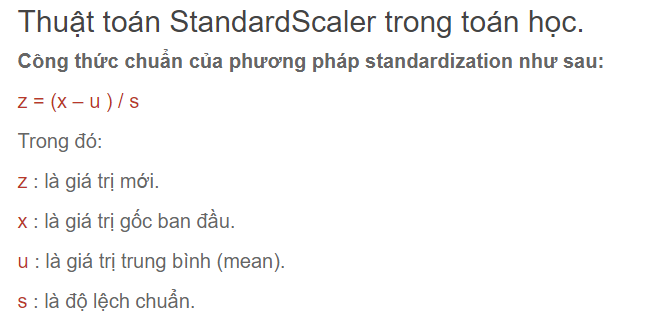

In [69]:
y = data['isFraud']

Các trị riêng cho biết lượng thông tin mà mỗi thành phần chính chứa đựng. Dựa vào đó, chúng ta giữ lại những thành phần có trị riêng lớn để giảm chiều, đồng thời bỏ đi các thành phần có trị riêng nhỏ vì chúng đóng góp ít vào tổng phương sai.

In [76]:
# các tham số trong PCA
pca = PCA(n_components=None, whiten=False, svd_solver='randomized', iterated_power=5, random_state=42)
X_pca = pca.fit_transform(X_scaled)

In [73]:
# Hiển thị trị riêng (explained_variance_ratio_)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

In [77]:
# Hiển thị vector riêng (Eigenvectors)
print("\nVector riêng (Eigenvectors):")
eigenvectors = pca.components_
print(eigenvectors)


Vector riêng (Eigenvectors):
[[-2.50160932e-01 -1.33183411e-01  1.80276191e-02  6.35099845e-02
  -3.12371813e-01 -4.50473729e-01 -1.11592339e-01  3.43137754e-04
   1.53121333e-02  3.99614729e-02 -3.44404513e-01  4.96832557e-01
  -4.84849500e-01]
 [-2.66405283e-01 -1.90971800e-01 -2.11357886e-01  1.93423831e-01
   2.61034759e-01 -2.78088479e-01 -2.40017813e-01  1.96871727e-01
   2.28741379e-01  2.79035060e-01 -4.45072840e-01 -3.19997603e-01
   3.71432638e-01]
 [ 8.11497020e-02 -5.82078388e-01  5.48861876e-01 -3.73203638e-01
   2.17019836e-01  1.44379247e-01 -1.04090112e-01  8.06881166e-02
   3.40979340e-01  3.35147128e-02 -3.71512844e-03  9.65817617e-02
  -4.52645334e-02]
 [ 3.40021869e-01  1.44876034e-01  1.74066510e-01  1.27428856e-01
  -2.54959352e-01  6.59877883e-02 -3.23437064e-01  6.67002585e-01
  -3.61570801e-02 -3.85341679e-01 -2.03827525e-01 -8.00651544e-02
   1.56373067e-02]
 [ 2.20729054e-01 -4.18495767e-02 -1.59967106e-01  3.27025469e-01
  -5.86924183e-02 -4.64365209e-02 -1

In [75]:
eigenvectors_df = pd.DataFrame(eigenvectors, columns=df_combined.columns[:len(explained_variance)])

In [78]:
# Tạo DataFrame cho vector riêng để hiển thị dễ hiểu hơn
eigenvalues_df = pd.DataFrame(explained_variance, columns=['Eigenvalue'])

In [79]:
eigenvalues_df['Component'] = eigenvalues_df.index + 1

In [80]:
# Hiển thị cả vector riêng và giá trị riêng
combined_df = pd.concat([eigenvalues_df, eigenvectors_df], axis=1)
print("\nCombined Eigenvalues and Eigenvectors:")
print(combined_df)


Combined Eigenvalues and Eigenvectors:
    Eigenvalue  Component  TransactionAmt     card1     card2     card3  \
0     0.197754          1       -0.250161 -0.133183  0.018028  0.063510   
1     0.173535          2       -0.266405 -0.190972 -0.211358  0.193424   
2     0.103906          3        0.081150 -0.582078  0.548862 -0.373204   
3     0.094519          4        0.340022  0.144876  0.174067  0.127429   
4     0.080415          5        0.220729 -0.041850 -0.159967  0.327025   
5     0.076162          6        0.356840  0.217032 -0.495636 -0.638707   
6     0.071333          7       -0.296909  0.071116 -0.044073 -0.136484   
7     0.065843          8        0.386490 -0.313831 -0.143157  0.340016   
8     0.047363          9       -0.305472  0.340374  0.323181 -0.177576   
9     0.044896         10        0.096740  0.550224  0.315898  0.230444   
10    0.026748         11        0.473500  0.068614  0.342582 -0.105416   
11    0.014610         12       -0.052160 -0.086898 -0.09031

In [81]:
print("Trị riêng (Explained Variance Ratio):")
print(explained_variance)

Trị riêng (Explained Variance Ratio):
[0.1977541  0.17353547 0.10390627 0.09451917 0.08041537 0.07616232
 0.07133312 0.06584307 0.0473631  0.0448964  0.02674821 0.01460977
 0.00291362]


In [82]:
print("\nPhương sai tích lũy:")
print(cumulative_variance)


Phương sai tích lũy:
[0.1977541  0.37128957 0.47519584 0.56971501 0.65013038 0.7262927
 0.79762583 0.8634689  0.910832   0.9557284  0.98247662 0.99708638
 1.        ]


Phương sai tích lũy: Xác định bao nhiêu phần trăm phương sai (thông tin) của dữ liệu ban đầu được giữ lại. Ví dụ, nếu bạn giữ lại 95% phương sai, thì bạn cần chọn đủ thành phần sao cho tổng phương sai tích lũy đạt 95%.

In [83]:
print(f"\nSố lượng thành phần chính nên giữ lại (khi tổng phương sai đạt >= 67%): {sum(cumulative_variance <= 0.67) + 1}")


Số lượng thành phần chính nên giữ lại (khi tổng phương sai đạt >= 67%): 6


biểu đồ Scree Plot

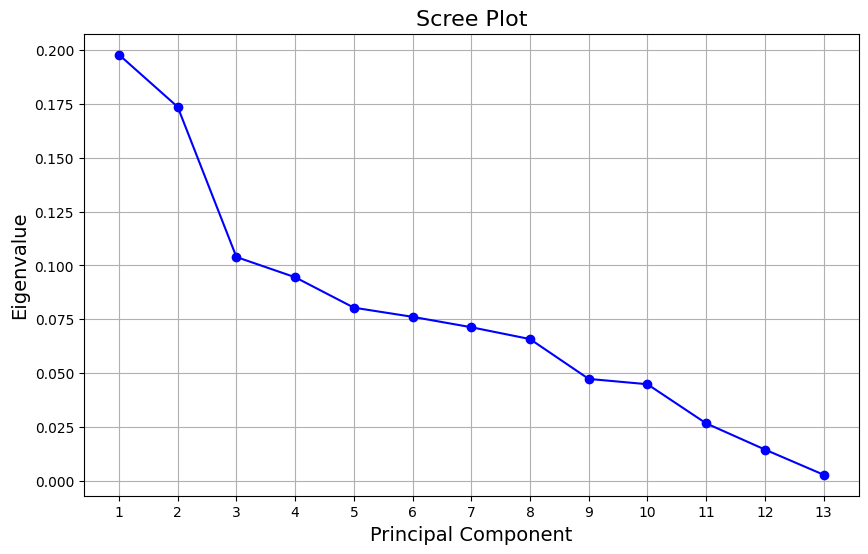

In [85]:
# Vẽ biểu đồ Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, 'o-', color='b')
plt.title('Scree Plot', fontsize=16)
plt.xlabel('Principal Component', fontsize=14)
plt.ylabel('Eigenvalue', fontsize=14)
plt.xticks(np.arange(1, len(explained_variance) + 1))
plt.grid(True)
plt.show()

In [86]:
# Hiển thị dữ liệu sau khi giảm chiều
print("Dữ liệu sau khi giảm chiều PCA:")
print(X_pca)

Dữ liệu sau khi giảm chiều PCA:
[[-2.74732548e+00 -1.68917646e+00  6.04188398e-01  1.37273019e+00
   3.36185401e-01  4.65664217e-01 -1.15485741e+00  4.78030485e-01
  -1.08420967e-01  1.68451328e+00  1.44145786e+00  3.59071126e-02
  -2.31705791e-01]
 [ 1.51406645e+00 -2.60324512e+00 -3.26824905e-01  7.71320054e-01
   4.81232560e-02 -5.42889301e-01 -4.68640714e-01  1.01883372e-01
   1.30276385e+00  1.12450264e+00 -1.61701009e-01 -4.71837527e-01
  -3.06090251e-01]
 [-1.10530966e+00  5.88156431e-01 -6.74907450e-01 -6.40994267e-01
   1.01024715e-01  3.88618138e-01 -1.19834060e-01 -5.64882097e-01
  -4.33535247e-01 -6.29179061e-01 -8.16130365e-01  8.83179861e-02
   4.72194415e-02]
 [-1.36215209e+00  2.33719341e-01 -1.36021436e+00 -1.90006540e-01
   2.24913515e-01  9.40940780e-01 -3.26464516e-01 -7.76006935e-01
  -2.24326953e-01  9.08683297e-02 -3.30186839e-01 -1.29991422e-01
  -3.39682105e-02]
 [ 2.45831120e-01  3.22261665e+00  2.87637467e+00 -2.77452670e-01
   4.30791366e+00  1.71169288e+00 

Trực quan hóa PCA

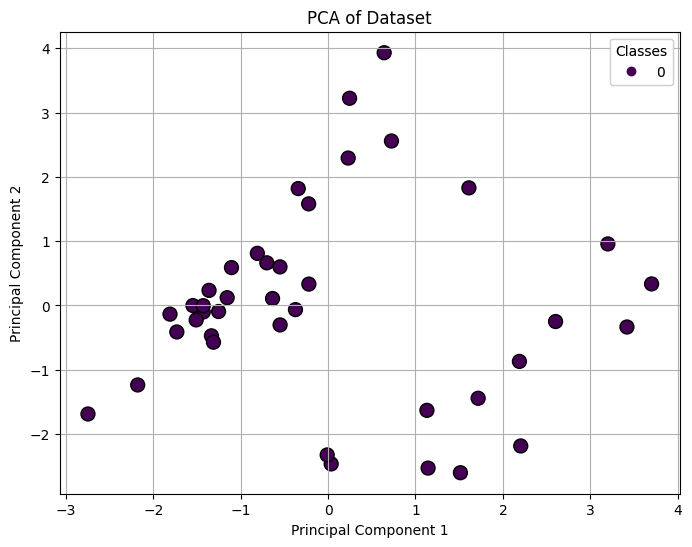

In [87]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=100)
plt.title('PCA of Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Thêm legend
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)
plt.grid()
plt.show()

với dữ liệu ban đầu tập data chứa các thuộc tính: ['isFraud','TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'addr1', 'dist1', 'P_emaildomain', 'dist2', 'R_emaildomain', 'C1'].
- theo kết quả của ma trận hiệp phương sai sau khi đã chuẩn hóa dữ liệu, các giá trị trị riêng được sắp xếp giảm dần: TransactionAmt, card1, card2, card3, card5.